### 1. Semantic Segmentation
- Label each pixel in the image with a category label
- Don't differentiate instances, only care about pixels


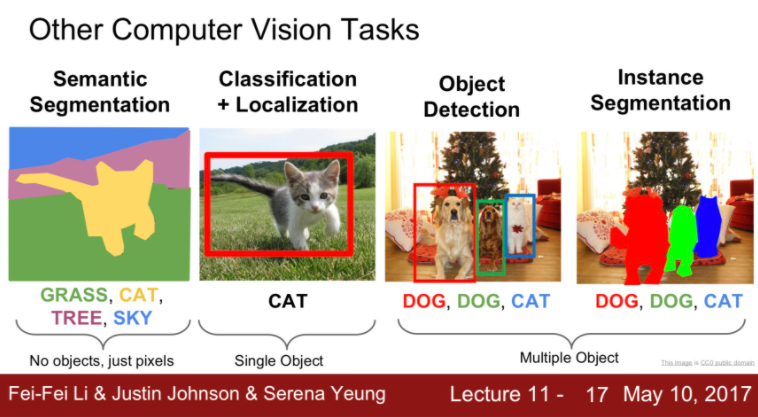

In [31]:
#@title <CS231>
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/Practice/img/0424_1.png')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.9MB 5.8MB/s 


### 2. Load Data
- Oxford-IIIT Pet Dataset
- Each pixel is given one of 3 categories
> Class 1 : Pixel belonging to the pet  
> Class 2 : Pixel bordering the pet  
> Class 3 : None of the above / Surrounding pixel

In [3]:
import tensorflow as tf

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
 # segmentation mask는 version 3이상에 포함되어 있음

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [7]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_ex

### 3. Augmentation & Preprocessing
- perform a simple augmentation of flipping an image
- image is normalized to [0, 1]
- subtract 1 from the segmentation mask : {1, 2, 3} -> {0, 1, 2}

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
                    # tf.cast : 새로운 형태로 캐스팅
    input_mask -= 1
    return input_image, input_mask

In [9]:
@tf.function  
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    # augmentation (flipping)
    if tf.random.uniform(()) > 0.5:  # shape가 '()'인 것! - '스칼라' / '순위-0' 텐서
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

- @tf.function 데코레이터를 사용하면 자동으로 computational graph를 만들어 줌 

In [10]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

#### train / test split

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples  # train 개수
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

- tf.data.AUTOTUNE으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정하도록 만듦 (스스로 병렬 처리 수준을 최적화하도록 결정을 위임)
- data.map : function을 dataset의 각 원소에 apply

In [13]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

- cache 변환은 cache 이전의 변환(데이터 읽기 등)은 첫 번째 에포크 동안에만 실행. 다음 에포크에서는 cache 변환에 의해 케시된 데이터를 재사용
- repeat은 데이터를 모두 사용할 때까지, 배치들을 만들어 줌
- prefetch s번째 샘플을 훈련하는 동안, s+1번째 샘플에 대한 전처리 수행

#### Explore the data

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

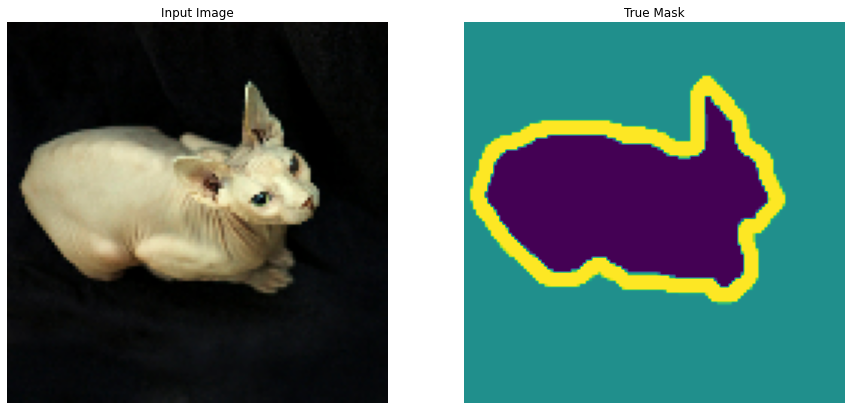

In [15]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

- take(1) : (data, label)을 리턴
- array_to_img : numpy.array를 PIL 이미지 인스턴스로 변환

### 4. Define the model
- modified U-Net
- A U-Net consists of an encoder (downsampler) and decoder (upsampler)
- Use a pretrained model   
    ○ For encoder, will be used a pretrained __MobileNetV2__ model, whose intermediate outputs will be used,  
    ○ For decoder, will be the __upsample block__ implemented in TensorFlow Examples [ref.](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py))

In [16]:
OUTPUT_CHANNELS = 3  # three possible labels

In [17]:
### encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3],
                                              include_top = False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [18]:
### decoder/upsampler
up_stack = [
    pix2pix.upsample(512, 3),  # 4*4 -> 8*8
    pix2pix.upsample(256, 3),  # 8*8 -> 16*16
    pix2pix.upsample(128, 3),  # 16*16 -> 32*32
    pix2pix.upsample(64, 3)    # 32*32 -> 64*64
]

# upsample : Conv2DTranspose => Batchnorm => Dropout => Relu

In [19]:
def unet_model(output_channels):  # 아래의 모델 그림 참고
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # This is the last layer of te model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,
                                           padding='same')  # 64*64 -> 128*128
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

### 4. Train the model
- loss : SparseCategoricalCrossentropy (because the network is trying to assign each pixel a label, just like multi-class prediction)

In [20]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

- from_logits=True : normalize 되었는지 or 안되었는지
-  softmax 함수를 거치면 from_logits = False(default값), 그렇지 않으면 from_logits = True

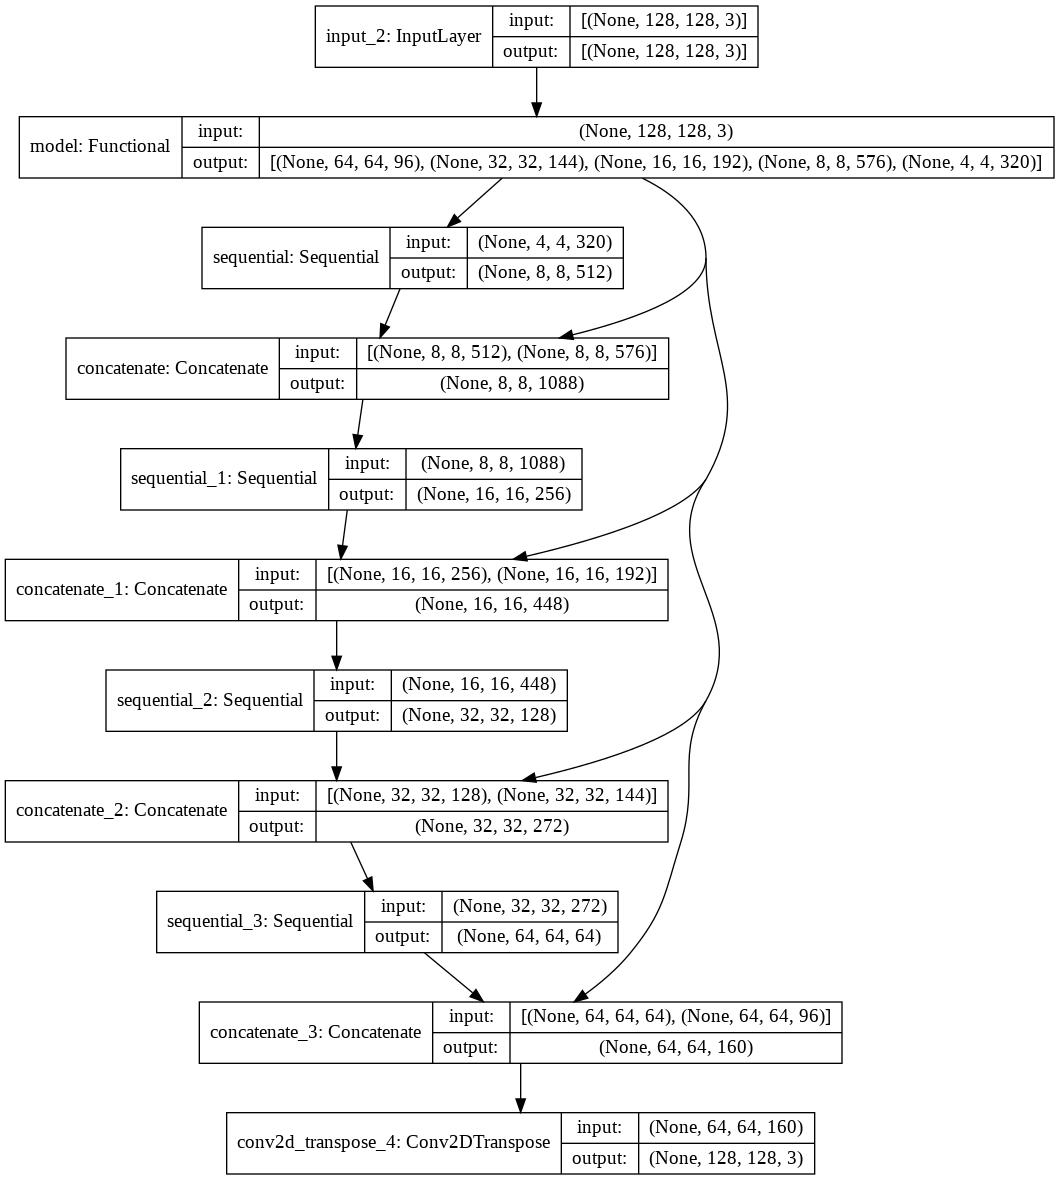

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Before training 
- sample_image and sample_mask

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)  # axis=-1 : 마지막 axis
    pred_mask = pred_mask[..., tf.newaxis]      # 채널 차원 추가 
                                                # ex. (3, 3) -> (3, 3, 1)
    return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])

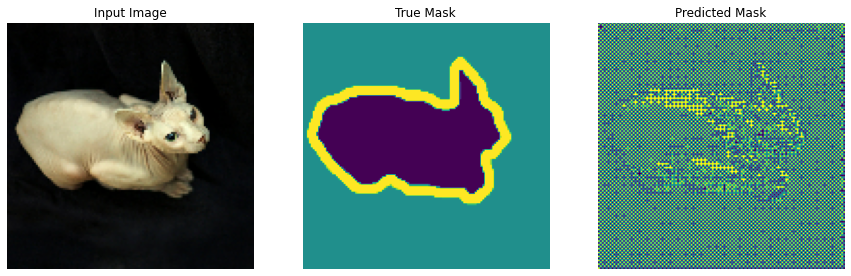

In [24]:
show_predictions()

#### Train

In [25]:
# 에폭마다 훈련상태를 시각화해주는 callback
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            clear_output(wait= True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

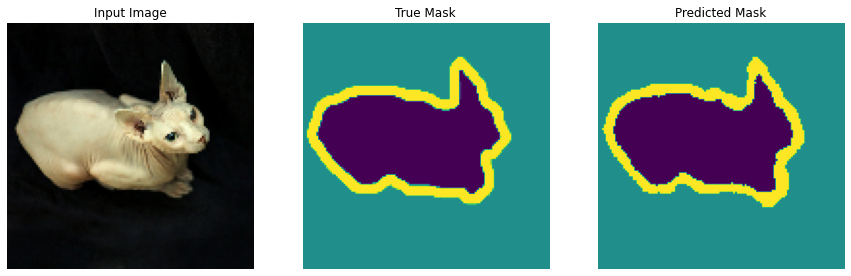


Sample Prediction after epoch 20



In [26]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_dataset,
                         callbacks=[DisplayCallback()])

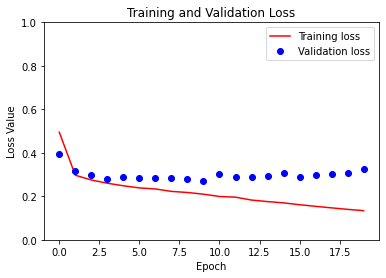

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 6. Make predictions

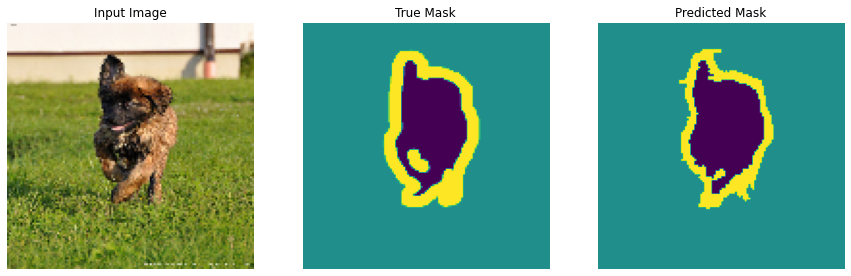

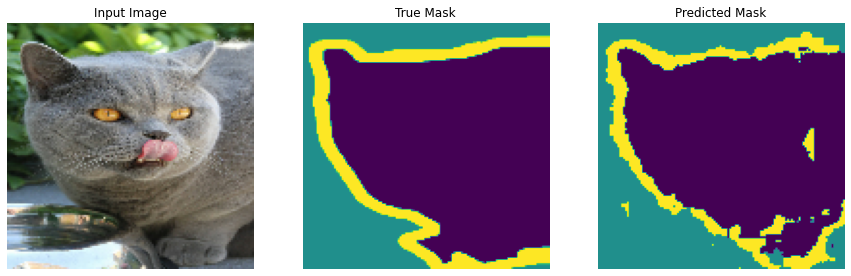

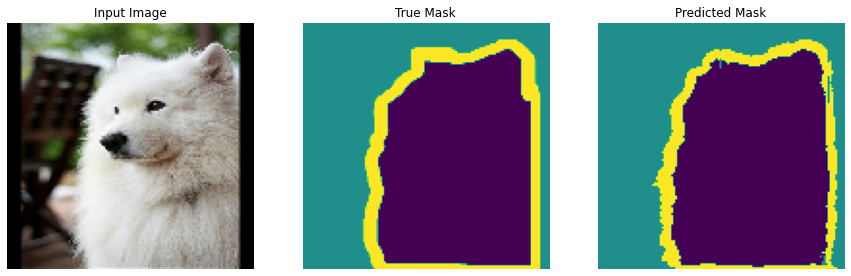

In [30]:
show_predictions(test_dataset, 3)